In [1]:
pip install boto3 tensorflow-datasets matplotlib git+https://github.com/tensorflow/examples.git ipywidgets tqdm

  Cloning https://github.com/tensorflow/examples.git to /tmp/pip-req-build-ts6nb8ro
  Running command git clone -q https://github.com/tensorflow/examples.git /tmp/pip-req-build-ts6nb8ro
You should consider upgrading via the '/usr/local/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [41]:
!rm -rf Images/
!rm -rf checkpoints/

In [42]:
import sagemaker
sagemaker_session = sagemaker.Session()

In [44]:
sagemaker_session.download_data(path='Images/', bucket='sagemaker-kecleon', key_prefix='Images')
sagemaker_session.download_data(path='checkpoints/', bucket='sagemaker-kecleon', key_prefix='checkpoints')

OSError: [Errno 16] Device or resource busy: 'Images/..43AE41C6' -> 'Images/.'

In [3]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow_examples.models.pix2pix import pix2pix
import matplotlib.pyplot as plt

In [4]:
def download_file(file_id, file_name):
  from google.colab import auth
  auth.authenticate_user()
  from googleapiclient.discovery import build
  drive_service = build('drive', 'v3')

  import io
  from googleapiclient.http import MediaIoBaseDownload

  request = drive_service.files().get_media(fileId=file_id)
  downloaded = io.FileIO(file_name, 'wb')
  downloader = MediaIoBaseDownload(downloaded, request)
  done = False
  while done is False:
    status, done = downloader.next_chunk()
    print(f'Downloading {file_name}: {status.progress() * 100}%')

  downloaded.seek(0)

In [5]:
# download_file('12zNhWQgefLolgRH7oKvsqnSj4g0YVLqW', 'Contents.zip')
# download_file('1zclFEnO87Mpr8i11J44U9w4gW3g4Fgf4', 'Styles.zip')

In [95]:
!mkdir -p Images/train/Contents Images/train/Styles
!unzip -qod Images/train/Contents Contents.zip
!unzip -qod Images/train/Styles Styles.zip

In [6]:
builder = tfds.ImageFolder('Images')
ds = builder.as_dataset(split='train', shuffle_files=True)

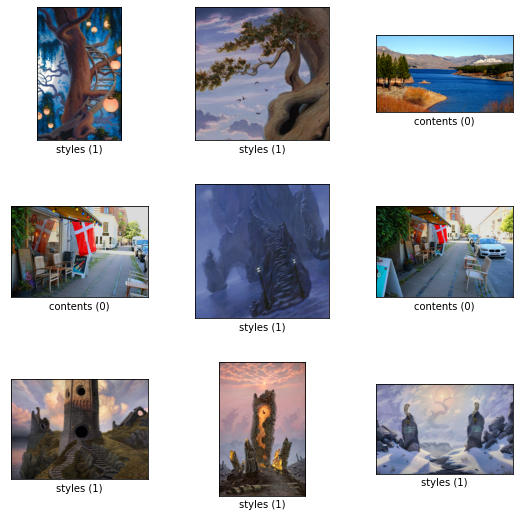

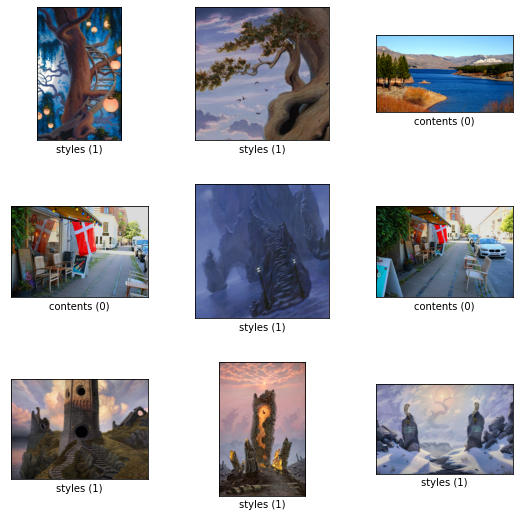

In [7]:
tfds.show_examples(ds, builder.info)

In [8]:
content_images = ds.filter(lambda i: i['label'] == 0)
style_images = ds.filter(lambda i: i['label'] == 1)

In [9]:
BUFFER_SIZE = 1000
BATCH_SIZE = 1
IMG_WIDTH = 256
IMG_HEIGHT = 256

In [10]:
def preprocess_image(image):
  image = tf.image.resize(image, [286, 286], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
  image = tf.image.random_crop(image, size=[IMG_HEIGHT, IMG_WIDTH, 3])
  image = tf.image.random_flip_left_right(image)

  image = tf.cast(image, tf.float32)
  image = (image / 127.5) - 1

  return image

def preprocess_record(record):
  image = record['image']
  return preprocess_image(image)

In [11]:
def get_preprocessed_dataset_batch(dataset):
  return dataset \
      .cache() \
      .map(preprocess_record) \
      .shuffle(BUFFER_SIZE) \
      .batch(BATCH_SIZE) \
      .repeat(2)

In [12]:
train_content = get_preprocessed_dataset_batch(content_images)
train_styles = get_preprocessed_dataset_batch(style_images)

test_content = get_preprocessed_dataset_batch(content_images)
test_styles = get_preprocessed_dataset_batch(style_images)

In [13]:
sample_content = next(iter(train_content))
sample_style = next(iter(train_styles))

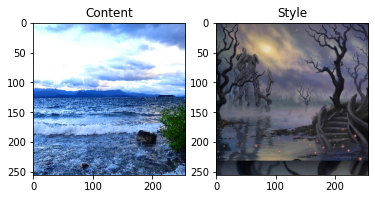

In [14]:
plt.subplot(121)
plt.title('Content')
plt.imshow(sample_content[0] * 0.5 + 0.5)

plt.subplot(122)
plt.title('Style')
plt.imshow(sample_style[0] * 0.5 + 0.5)

In [15]:
OUTPUT_CHANNELS = 3

generator_g = pix2pix.unet_generator(OUTPUT_CHANNELS, norm_type='instancenorm')
generator_f = pix2pix.unet_generator(OUTPUT_CHANNELS, norm_type='instancenorm')

discriminator_x = pix2pix.discriminator(norm_type='instancenorm', target=False)
discriminator_y = pix2pix.discriminator(norm_type='instancenorm', target=False)

[2021-08-30 01:51:30.304 tensorflow-2-3-gpu--ml-g4dn-xlarge-c85184389676cdfa7bdf06745c9b:593 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None
[2021-08-30 01:51:30.332 tensorflow-2-3-gpu--ml-g4dn-xlarge-c85184389676cdfa7bdf06745c9b:593 INFO profiler_config_parser.py:102] Unable to find config at /opt/ml/input/config/profilerconfig.json. Profiler is disabled.


## Loss functions

In [16]:
LAMBDA = 10

In [17]:
loss_obj = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [18]:
def discriminator_loss(real, generated):
  real_loss = loss_obj(tf.ones_like(real), real)

  generated_loss = loss_obj(tf.zeros_like(generated), generated)

  total_disc_loss = real_loss + generated_loss

  return total_disc_loss * 0.5

In [19]:
def generator_loss(generated):
  return loss_obj(tf.ones_like(generated), generated)

In [20]:
def calc_cycle_loss(real_image, cycled_image):
  cycle_loss = tf.reduce_mean(tf.abs(real_image - cycled_image))
  return LAMBDA * cycle_loss

In [21]:
def identity_loss(real_image, same_image):
  loss = tf.reduce_mean(tf.abs(real_image - same_image))
  return LAMBDA * 0.5 * loss

In [22]:
generator_g_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
generator_f_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

discriminator_x_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_y_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

## Checkpoints

In [23]:
checkpoint_path = "./checkpoints/train"

ckpt = tf.train.Checkpoint(generator_g=generator_g,
                           generator_f=generator_f,
                           discriminator_x=discriminator_x,
                           discriminator_y=discriminator_y,
                           generator_g_optimizer=generator_g_optimizer,
                           generator_f_optimizer=generator_f_optimizer,
                           discriminator_x_optimizer=discriminator_x_optimizer,
                           discriminator_y_optimizer=discriminator_y_optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=1)

# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
  ckpt.restore(ckpt_manager.latest_checkpoint)
  print('Restored existing checkpoint.')

In [24]:
EPOCHS = 5

In [25]:
def generate_images(model, test_input):
  prediction = model(test_input)
    
  plt.figure(figsize=(12, 12))

  display_list = [test_input[0], prediction[0]]
  title = ['Input Image', 'Predicted Image']

  for i in range(2):
    plt.subplot(1, 2, i+1)
    plt.title(title[i])

    # getting the pixel values between [0, 1] to plot it.
    plt.imshow(display_list[i] * 0.5 + 0.5)
    plt.axis('off')
  plt.show()

In [26]:
@tf.function
def train_step(real_x, real_y):
  # persistent is set to True because the tape is used more than
  # once to calculate the gradients.
  with tf.GradientTape(persistent=True) as tape:
    # Generator G translates X -> Y
    # Generator F translates Y -> X.
    
    fake_y = generator_g(real_x, training=True)
    cycled_x = generator_f(fake_y, training=True)

    fake_x = generator_f(real_y, training=True)
    cycled_y = generator_g(fake_x, training=True)

    # same_x and same_y are used for identity loss.
    same_x = generator_f(real_x, training=True)
    same_y = generator_g(real_y, training=True)

    disc_real_x = discriminator_x(real_x, training=True)
    disc_real_y = discriminator_y(real_y, training=True)

    disc_fake_x = discriminator_x(fake_x, training=True)
    disc_fake_y = discriminator_y(fake_y, training=True)

    # calculate the loss
    gen_g_loss = generator_loss(disc_fake_y)
    gen_f_loss = generator_loss(disc_fake_x)
    
    total_cycle_loss = calc_cycle_loss(real_x, cycled_x) + calc_cycle_loss(real_y, cycled_y)
    
    # Total generator loss = adversarial loss + cycle loss
    total_gen_g_loss = gen_g_loss + total_cycle_loss + identity_loss(real_y, same_y)
    total_gen_f_loss = gen_f_loss + total_cycle_loss + identity_loss(real_x, same_x)

    disc_x_loss = discriminator_loss(disc_real_x, disc_fake_x)
    disc_y_loss = discriminator_loss(disc_real_y, disc_fake_y)
  
  # Calculate the gradients for generator and discriminator
  generator_g_gradients = tape.gradient(total_gen_g_loss, generator_g.trainable_variables)
  generator_f_gradients = tape.gradient(total_gen_f_loss, generator_f.trainable_variables)
  
  discriminator_x_gradients = tape.gradient(disc_x_loss, discriminator_x.trainable_variables)
  discriminator_y_gradients = tape.gradient(disc_y_loss, discriminator_y.trainable_variables)
  
  # Apply the gradients to the optimizer
  generator_g_optimizer.apply_gradients(zip(generator_g_gradients, generator_g.trainable_variables))
  generator_f_optimizer.apply_gradients(zip(generator_f_gradients, generator_f.trainable_variables))
  
  discriminator_x_optimizer.apply_gradients(zip(discriminator_x_gradients, discriminator_x.trainable_variables))
  discriminator_y_optimizer.apply_gradients(zip(discriminator_y_gradients, discriminator_y.trainable_variables))

  0%|          | 0/5 [00:00<?, ?it/s]

0it [00:00, ?it/s]

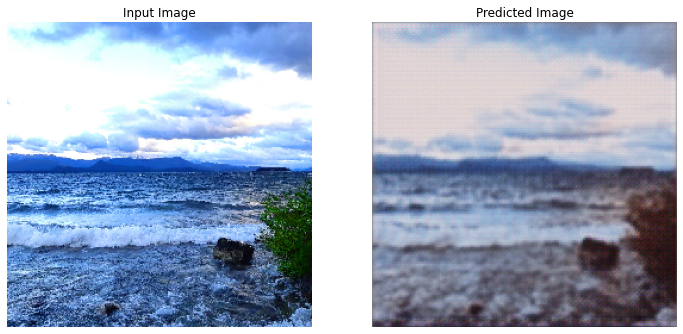

Saving checkpoint for epoch 1 at ./checkpoints/train/ckpt-1.


0it [00:00, ?it/s]

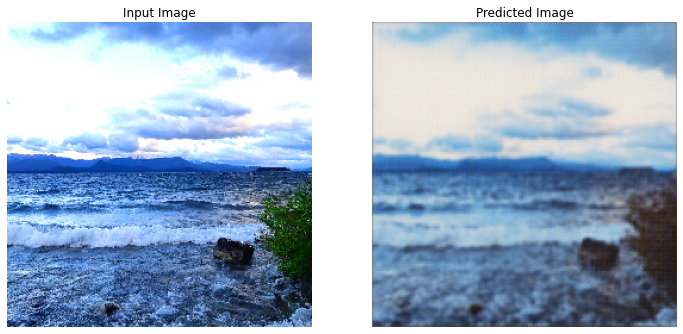

Saving checkpoint for epoch 2 at ./checkpoints/train/ckpt-2.


0it [00:00, ?it/s]

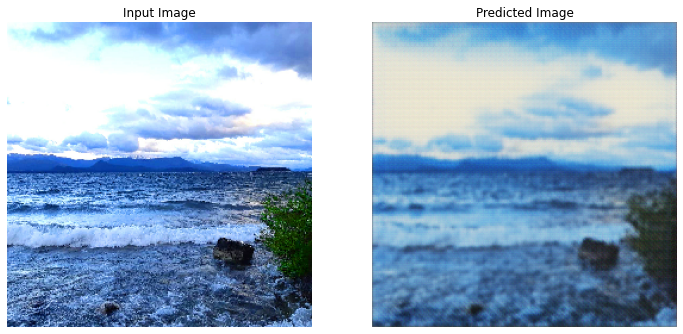

Saving checkpoint for epoch 3 at ./checkpoints/train/ckpt-3.


0it [00:00, ?it/s]

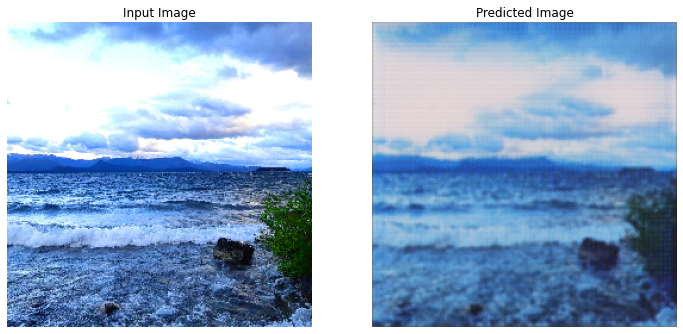

Saving checkpoint for epoch 4 at ./checkpoints/train/ckpt-4.


0it [00:00, ?it/s]

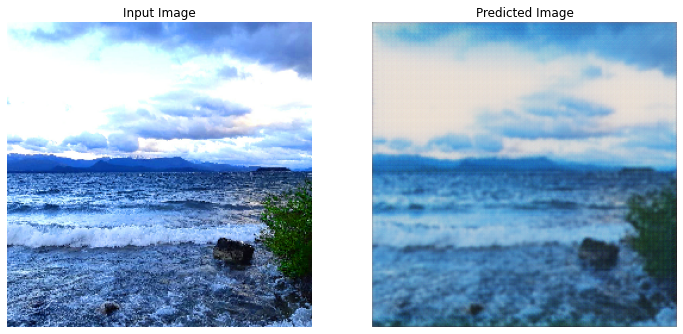

Saving checkpoint for epoch 5 at ./checkpoints/train/ckpt-5.


In [27]:
from tqdm.notebook import trange, tqdm

for epoch in trange(EPOCHS):
  for image_x, image_y in tqdm(tf.data.Dataset.zip((train_content, train_styles))):
    train_step(image_x, image_y)

  generate_images(generator_g, sample_content)

  ckpt_save_path = ckpt_manager.save()
  print(f'Saving checkpoint for epoch {epoch + 1} at {ckpt_save_path}.')

## Generate using test dataset

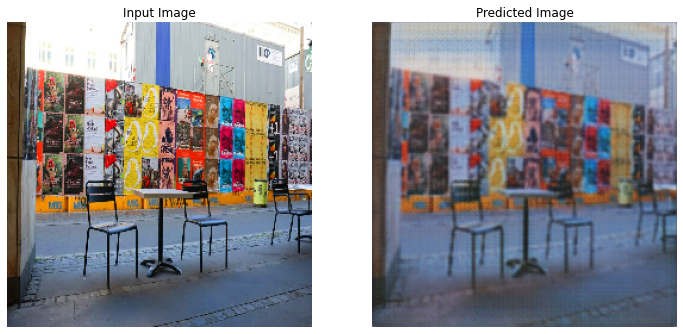

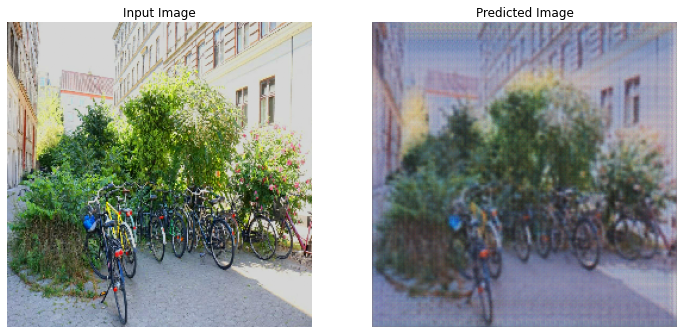

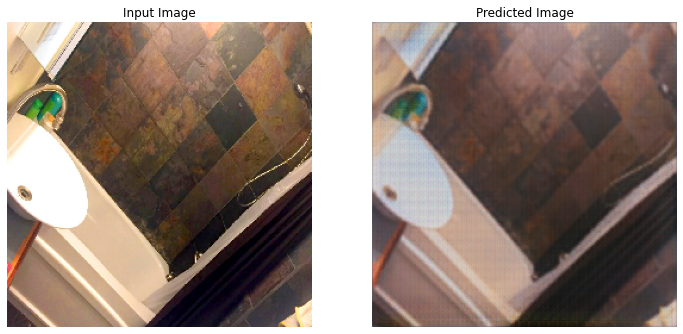

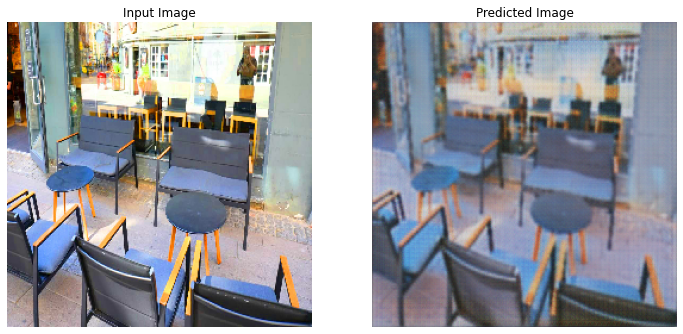

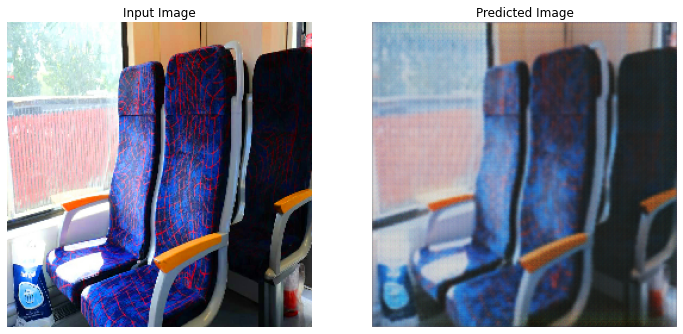

In [123]:
# Run the trained model on the test dataset
for inp in test_content.take(5):
  generate_images(generator_g, inp)

In [36]:
sagemaker_session.upload_data(bucket='sagemaker-kecleon', path='checkpoints', key_prefix='checkpoints')

's3://sagemaker-kecleon/checkpoints'

## Next steps

- solve darkening of images?
- create pipeline to process a whole image after generator has been trained
- More epochs (~200)
  - Improve timing on existing epochs
- Switch to ResNet instead of U-Net ([source](https://arxiv.org/abs/1703.10593))
- Obtain another implementation of pix2pix (maybe from TFHub?)